Main URL: https://www.kaggle.com/dhananjay3/image-segmentation-from-scratch-in-pytorch


# Image Segmentation using Pytorch
Table of Content: 

1. **Step 1: Load and datasets using torchvision**
2. **Step 2: Create Unet Architecture**
    - Define a Network
    - Define a loss function, Optimizer, lr scheduler
3. **Step 3: Neural Net Configuration**
    - Train the network on the training data
4. **Step 4: Dice Score**
    - Valid the network on the Train/Valid data
    - This competition is evaluated on the mean Dice coefficient. The Dice coefficient can be used to compare the pixel-wise agreement between a predicted segmentation and its corresponding ground truth. where X is the predicted set of pixels and Y is the ground truth. The Dice coefficient is defined to be 1 when both X and Y are empty. The leaderboard score is the mean of the Dice coefficients for each <Image, Label> pair in the test set.

    - The formula is given by: 
    
    **2∗|X∩Y|/|X|+|Y| **
    
    
    
**5. Step 5: Pending:**

   - Precision, recall, F-score and a ROC curve for EACH class.?? We need to calculate
   - Multiple fold scores


## Unet architecture
Unet: The UNET architecture contains two paths. First path is the contraction path (also called as the encoder) which is used to capture the context in the image. The encoder is just a traditional stack of convolutional and max pooling layers. The second path is the symmetric expanding path (also called as the decoder) which is used to enable precise localization using transposed convolutions.


Finally Huge thanks to **artgor, ryches, ratthachat, [repo1](https://github.com/qubvel/segmentation_models.pytorch/blob/master/segmentation_models_pytorch/utils/losses.py) ,[repo2](https://github.com/milesial/Pytorch-UNet) ** for their code

### **references**
1. https://www.kaggle.com/artgor/segmentation-in-pytorch-using-convenient-tools
2. https://www.kaggle.com/ryches/turbo-charging-andrew-s-pytorch
3. https://github.com/qubvel/segmentation_models.pytorch/blob/master/segmentation_models_pytorch/utils/losses.py
4. https://github.com/milesial/Pytorch-UNet
5. https://www.kaggle.com/ratthachat/cloud-convexhull-polygon-postprocessing-no-gpu

## Download Kaggle Dataset

In [0]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [0]:
!kaggle datasets download -d ryches/understanding-clouds-resized

 98% 985M/0.98G [00:10<00:00, 78.2MB/s]
100% 0.98G/0.98G [00:10<00:00, 102MB/s]


In [0]:
!mkdir data
!unzip understanding-clouds-resized.zip -d data > /dev/null
!kaggle datasets download -d hmnshu/cloudcsvfiles
!unzip cloudcsvfiles.zip -d data > /dev/null

data  kaggle.json  sample_data	understanding-clouds-resized.zip


## Dataset Content


In [0]:
!ls /content/data

test_images_525  train_images_525  train_masks_525


### Step 1 - IMPORTS

In [0]:
# plotly offline imports
#from plotly.offline import download_plotlyjs, init_notebook_mode, iplot
from plotly import subplots
import plotly.express as px
import plotly.figure_factory as ff
from plotly.graph_objs import *
from plotly.graph_objs.layout import Margin, YAxis, XAxis

import os, pdb
import gc
import cv2
import time
import tqdm
import random
import collections
import numpy as np
import pandas as pd
import seaborn as sns
from PIL import Image
from functools import partial
import matplotlib.pyplot as plt
from tqdm.auto import tqdm as tq
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score


import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim import lr_scheduler
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import TensorDataset, DataLoader, Dataset
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau

# ablumentations for easy image augmentation for input as well as output
import albumentations as albu
# from albumentations import torch as AT
plt.style.use('bmh')

In [0]:
# seeding function for reproducibility
def seed_everything(seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True


DATA_DIR = "/content/data"
TRAIN_DIR = os.path.join(DATA_DIR + "/train_images_525/train_images_525/")
MASK_DIR = os.path.join(DATA_DIR + "/train_masks_525/train_masks_525/")
train_on_gpu = torch.cuda.is_available()
SEED = 2019
MODEL_NO = 0 # in K-fold
N_FOLDS = 5 # in K-fold
seed_everything(SEED)
os.listdir(DATA_DIR)

['train_masks_525', 'train_images_525', 'test_images_525']

In [0]:
def ret_percentage(column):
    return round(column.value_counts(normalize=True) * 100,2)

train = pd.read_csv(DATA_DIR+"/train.csv") #.fillna(0)
train.head()

,Image_Label,EncodedPixels
0,0011165.jpg_Fish,264918 937 266318 937 267718 937 269118 937 27...
1,0011165.jpg_Flower,1355565 1002 1356965 1002 1358365 1002 1359765...
2,0011165.jpg_Gravel,NaN
3,0011165.jpg_Sugar,NaN
4,002be4f.jpg_Fish,233813 878 235213 878 236613 878 238010 881 23...


In [0]:
#Get target label and image name in separate column
train["label"] = train["Image_Label"].apply(lambda x: x.split("_")[1])
train["img_name"] = train["Image_Label"].apply(lambda x: x.split("_")[0])
# lets create a dict with class id and encoded pixels and group all the defaults per image
train['Label_EncodedPixels'] = train.apply(lambda row: (row['label'], row['EncodedPixels']), axis = 1)
sub = pd.read_csv(f"{DATA_DIR}/sample_submission.csv")
sub["label"] = sub["Image_Label"].apply(lambda x: x.split("_")[1])
sub["img_name"] = sub["Image_Label"].apply(lambda x: x.split("_")[0])
train.shape

(22184, 5)

In [0]:
print('Total number of images: %s' % len(train['img_name'].unique()))
print('Images with at least one label: %s' % len(train[train['EncodedPixels'].isnull() == False]['img_name'].unique()))
print('Total instance or examples of NaN: %s' % len(train[train['EncodedPixels'].isnull() == False]))

Total number of images: 5546
Images with at least one label: 5546
Total instance or examples of NaN: 11836


In [0]:
# different types of clouds we have in our dataset
train['label'].unique()

array(['Fish', 'Flower', 'Gravel', 'Sugar'], dtype=object)

In [0]:
# lets group each of the types and their mask in a list so we can do more aggregated counts
grouped_EncodedPixels = train.groupby('img_name')['Label_EncodedPixels'].apply(list)
# count the number of labels per image has
labels_per_image_count = grouped_EncodedPixels.apply(lambda x: len([x[0] for x in x if str(x[1]) != "nan"])).value_counts()
# count frequency of each type of cloud
label_type_per_image = train[train['EncodedPixels'].isnull() == False]['label'].value_counts()
# now we have the data ready lets plot them to answer our questions
trace0 = Bar(x=labels_per_image_count.index, y=labels_per_image_count.values, name = 'Number of Cloud Types Per Image')
trace1 = Bar(x=label_type_per_image.index, y=label_type_per_image.values, name = 'Frequency of Different Clouds')
fig = subplots.make_subplots(rows=1, cols=2)
fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 1, 2)
fig['layout'].update(height=400, width=900, title='Label Count and Frequency Per Image')
fig.show()

In [0]:
from matplotlib import patches as patches

def bounding_box(img):
    # return max and min of a mask to draw bounding box
    rows = np.any(img, axis=1)
    cols = np.any(img, axis=0)
    rmin, rmax = np.where(rows)[0][[0, -1]]
    cmin, cmax = np.where(cols)[0][[0, -1]]

    return rmin, rmax, cmin, cmax

def plot_cloud(img_path, img_id, label_mask, mask_path):
    img = cv2.imread(os.path.join(img_path, img_id))
    height, width = img.shape[:2]
    
    fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(20,10))
    ax[0].imshow(img)
    ax[1].imshow(img)
    cmaps = {'Fish': 'Blues', 'Flower': 'Reds', 'Gravel': 'Greys', 'Sugar':'Purples'}
    colors = {'Fish': 'Blue', 'Flower': 'Red', 'Gravel': 'Gray', 'Sugar':'Purple'}
    for label, mask in label_mask:
        #print(MASK_DIR + label + img_id)
        mask_decoded = cv2.imread(mask_path + label + img_id)
        if mask_decoded is None:
          continue
        mask_decoded = cv2.resize(mask_decoded, (width, height), interpolation=cv2.INTER_NEAREST)
        if mask != -1:
            rmin, rmax, cmin, cmax = bounding_box(mask_decoded)
            bbox = patches.Rectangle((cmin,rmin),cmax-cmin,rmax-rmin,linewidth=2,edgecolor=colors[label],facecolor='none')
            ax[0].add_patch(bbox)
            ax[0].text(cmin, rmin, label, bbox=dict(fill=True, color=colors[label]))
            ax[1].imshow(mask_decoded, alpha=0.3, cmap=cmaps[label])
            ax[0].text(cmin, rmin, label, bbox=dict(fill=True, color=colors[label]))

def viz_masks(train, train_path, mask_path, index):
  print(index)
  img = cv2.imread(train_path + train['img_name'][index])
  height, width = img.shape[:2]
  mask_decoded = cv2.imread(mask_path + train['label'][index] + train['img_name'][index])
  mask_decoded = cv2.resize(mask_decoded, (width, height), interpolation=cv2.INTER_NEAREST)
  fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,10))
  print(train['label'][index])
  ax[0].imshow(img, cmap = plt.cm.gray)
  #ax[1].imshow(mask_decoded, alpha=0.3)
  # visualize the image and map
  ax[1].imshow(img, cmap = plt.cm.gray)
  ax[1].imshow(mask_decoded, alpha=0.3, cmap='Reds')

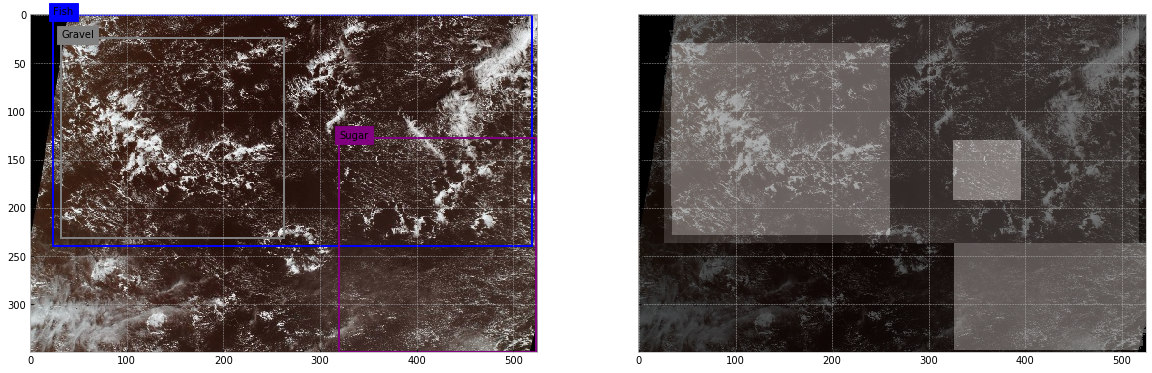

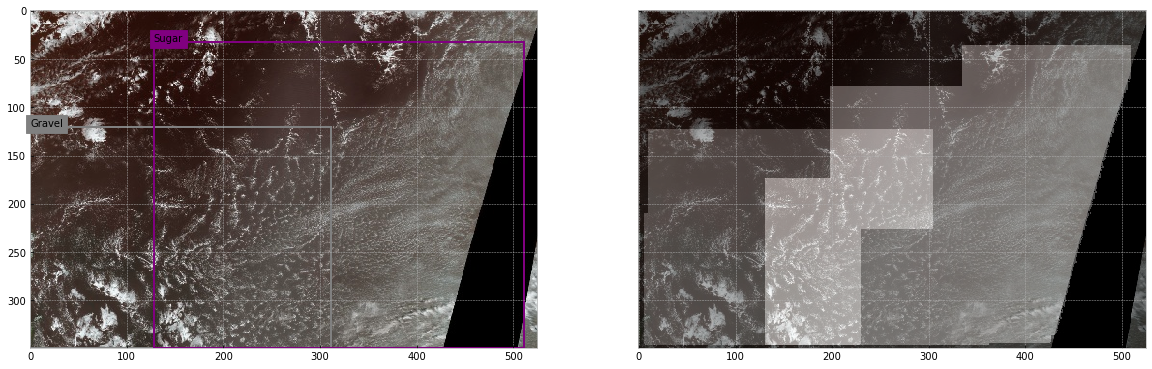

In [0]:
for image_id, label_mask in grouped_EncodedPixels.sample(2).iteritems():
  plot_cloud(TRAIN_DIR, image_id, label_mask, MASK_DIR)

In [0]:
# get image and segment mask count on each image
id_mask_count = (
    train.loc[train["EncodedPixels"].isnull() == False, "Image_Label"]
    .apply(lambda x: x.split("_")[0])
    .value_counts()
    .sort_index()
    .reset_index()
    .rename(columns={"index": "img_id", "Image_Label": "count"})
)

ids = id_mask_count["img_id"].values

#StratifiedKFold split - count of segments
li = [
    [train_index, test_index]
    for train_index, test_index in StratifiedKFold(
        n_splits=N_FOLDS, random_state=SEED
    ).split(ids, id_mask_count["count"])
]
print(N_FOLDS, " folds and Size of each train set", len(li[0][0]), " and valid set", len(li[0][1]))

5  folds and Size of each train set 4435  and valid set 1111


In [0]:
train_ids, valid_ids = ids[li[MODEL_NO][0]], ids[li[MODEL_NO][1]]  ##Only Kfold 0 is trained here
test_ids = sub["Image_Label"].apply(lambda x: x.split("_")[0]).drop_duplicates().values

print(f"training set   {train_ids[:5]}.. with length {len(train_ids)}")
print(f"validation set {valid_ids[:5]}.. with length {len(valid_ids)}")
print(f"testing set    {test_ids[:5]}.. with length {len(test_ids)}")

training set   ['2b03476.jpg' '2ba6090.jpg' '2d09e66.jpg' '2e4f5ab.jpg' '2f1f439.jpg'].. with length 4435
validation set ['0011165.jpg' '002be4f.jpg' '0031ae9.jpg' '0035239.jpg' '003994e.jpg'].. with length 1111
testing set    ['002f507.jpg' '0035ae9.jpg' '0038327.jpg' '004f759.jpg' '005ba08.jpg'].. with length 3698


## Load and datasets using torchvision

Helper Functions

**Thresholding** - https://pythonprogramming.net/thresholding-image-analysis-python-opencv-tutorial/

![alt text](https://s3-ap-south-1.amazonaws.com/av-blog-media/wp-content/uploads/2019/03/Screenshot-from-2019-03-29-12-08-40.png)

**Convex Hull**
Therefore, the Convex Hull of a shape or a group of points is a tight fitting convex boundary around the points or the shape.

https://www.learnopencv.com/convex-hull-using-opencv-in-python-and-c/

<img src="https://www.learnopencv.com/wp-content/uploads/2018/08/convex-hull.jpg)" alt="Drawing" width="400"/>

**cv2.drawContours:** Its first argument is source image, second argument is the contours which should be passed as a Python list, third argument is index of contours (useful when drawing individual contour. To draw all contours, pass -1) and remaining arguments are color, thickness etc.

https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_contours/py_contours_begin/py_contours_begin.html



In [0]:
# helper functions
class_names = ['Fish', 'Flower', 'Sugar', 'Gravel']

def draw_convex_hull(mask, mode='convex'):
    
    img = np.zeros(mask.shape)
    image, contours, hier = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
#https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_contours/py_contours_begin/py_contours_begin.html
    for c in contours:
        if mode=='rect': # simple rectangle
            x, y, w, h = cv2.boundingRect(c)
            cv2.rectangle(img, (x, y), (x+w, y+h), (255, 255, 255), -1)
        if mode=='convex': # minimum convex hull
            hull = cv2.convexHull(c)
            cv2.drawContours(img, [hull], 0, (255, 255, 255),-1)
        else: # minimum area rectangle
            rect = cv2.minAreaRect(c)
            box = cv2.boxPoints(rect)
            box = np.int0(box)
            cv2.drawContours(img, [box], 0, (255, 255, 255),-1)
    return img/255.

def get_img(x, folder: str = "train_images_525/train_images_525"):
    """
    Return image based on image name and folder.
    """
    data_folder = f"{img_paths}/{folder}"
    image_path = os.path.join(data_folder, x)
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img


def rle_decode(mask_rle: str = "", shape: tuple = (1400, 2100)):
    """
    Decode rle encoded mask.

    :param mask_rle: run-length as string formatted (start length)
    :param shape: (height, width) of array to return
    Returns numpy array, 1 - mask, 0 - background
    """
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0] * shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape, order="F")


def make_mask(df: pd.DataFrame, image_name: str = "img.jpg", shape: tuple = (350, 525)):
    """
    Create mask based on df, image name and shape.
    """
    masks = np.zeros((shape[0], shape[1], 4), dtype=np.float32)
    df = df[df["img_name"] == image_name]
    for idx, im_name in enumerate(df["img_name"].values):
        for classidx, classid in enumerate(["Fish", "Flower", "Gravel", "Sugar"]):
            mask = cv2.imread(
                DATA_DIR + "/train_masks_525/train_masks_525/"
                + classid
                + im_name
            )
            if mask is None:
                continue
            if mask[:, :, 0].shape != (350, 525):
                mask = cv2.resize(mask, (525, 350))
            masks[:, :, classidx] = mask[:, :, 0]
    masks = masks / 255
    return masks


def to_tensor(x, **kwargs):
    """
    Convert image or mask.
    """
    return x.transpose(2, 0, 1).astype("float32")


def mask2rle(img):
    """
    Convert mask to rle.
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    """
    pixels = img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return " ".join(str(x) for x in runs)


def visualize(image, mask, original_image=None, original_mask=None):
    """
    Plot image and masks.
    If two pairs of images and masks are passes, show both.
    """
    fontsize = 14
    class_dict = {0: "Fish", 1: "Flower", 2: "Gravel", 3: "Sugar"}

    if original_image is None and original_mask is None:
        f, ax = plt.subplots(1, 5, figsize=(24, 24))

        ax[0].imshow(image)
        for i in range(4):
            ax[i + 1].imshow(mask[:, :, i])
            ax[i + 1].set_title(f"Mask {class_dict[i]}", fontsize=fontsize)
    else:
        f, ax = plt.subplots(2, 5, figsize=(24, 12))

        ax[0, 0].imshow(original_image)
        ax[0, 0].set_title("Original image", fontsize=fontsize)

        for i in range(4):
            ax[0, i + 1].imshow(original_mask[:, :, i])
            ax[0, i + 1].set_title(f"Original mask {class_dict[i]}", fontsize=fontsize)

        ax[1, 0].imshow(image)
        ax[1, 0].set_title("Transformed image", fontsize=fontsize)

        for i in range(4):
            ax[1, i + 1].imshow(mask[:, :, i])
            ax[1, i + 1].set_title(
                f"Transformed mask {class_dict[i]}", fontsize=fontsize
            )


def visualize_with_raw(
    image, mask, original_image=None, original_mask=None, raw_image=None, raw_mask=None
):
    """
    Plot image and masks.
    If two pairs of images and masks are passes, show both.
    """
    fontsize = 14
    class_dict = {0: "Fish", 1: "Flower", 2: "Gravel", 3: "Sugar"}

    f, ax = plt.subplots(3, 5, figsize=(24, 12))

    ax[0, 0].imshow(original_image)
    ax[0, 0].set_title("Original image", fontsize=fontsize)

    for i in range(4):
        ax[0, i + 1].imshow(original_mask[:, :, i])
        ax[0, i + 1].set_title(f"Original mask {class_dict[i]}", fontsize=fontsize)

    ax[1, 0].imshow(raw_image)
    ax[1, 0].set_title("Original image", fontsize=fontsize)

    for i in range(4):
        ax[1, i + 1].imshow(raw_mask[:, :, i])
        ax[1, i + 1].set_title(f"Raw predicted mask {class_dict[i]}", fontsize=fontsize)

    ax[2, 0].imshow(image)
    ax[2, 0].set_title("Transformed image", fontsize=fontsize)

    for i in range(4):
        ax[2, i + 1].imshow(mask[:, :, i])
        ax[2, i + 1].set_title(
            f"Predicted mask with processing {class_dict[i]}", fontsize=fontsize
        )


def plot_with_augmentation(image, mask, augment):
    """
    Wrapper for `visualize` function.
    """
    augmented = augment(image=image, mask=mask)
    image_flipped = augmented["image"]
    mask_flipped = augmented["mask"]
    visualize(image_flipped, mask_flipped, original_image=image, original_mask=mask)


# sigmoid = lambda x: 1 / (1 + np.exp(-x))
def sigmoid(x):
    return 1 / (1 + np.exp(-x))



def post_process(probability, threshold, min_size):
    """
    This is slightly different from other kernels as we draw convex hull here itself.
    Post processing of each predicted mask, components with lesser number of pixels
    than `min_size` are ignored
    """
    # don't remember where I saw it
    mask = (cv2.threshold(probability, threshold, 1, cv2.THRESH_BINARY)[1])
    mask = draw_convex_hull(mask.astype(np.uint8))
    num_component, component = cv2.connectedComponents(mask.astype(np.uint8))
    #https://codeday.me/en/qa/20190306/12442.html
    #https://www.kaggle.com/alexanderliao/foreground-retrieval-with-cv2-connectedcomponents
    predictions = np.zeros((350, 525), np.float32)
    num = 0
    for c in range(1, num_component):
        p = component == c
        if p.sum() > min_size:
            predictions[p] = 1
            num += 1
    return predictions, num

def get_training_augmentation():
    train_transform = [
        albu.HorizontalFlip(p=0.5),
        albu.ShiftScaleRotate(
            scale_limit=0.5,
            rotate_limit=0,
            shift_limit=0.1,
            p=0.5,
            border_mode=0
        ),
        albu.GridDistortion(p=0.5),
        albu.Resize(320, 640),
        albu.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ]
    return albu.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        albu.Resize(320, 640),
        albu.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ]
    return albu.Compose(test_transform)


def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform

    Args:
        preprocessing_fn (callbale): data normalization function
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose

    """

    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)


def dice(img1, img2):
    img1 = np.asarray(img1).astype(np.bool)
    img2 = np.asarray(img2).astype(np.bool)

    intersection = np.logical_and(img1, img2)

    return 2.0 * intersection.sum() / (img1.sum() + img2.sum())

def dice_no_threshold(
    outputs: torch.Tensor,
    targets: torch.Tensor,
    eps: float = 1e-7,
    threshold: float = None,
):
    """
    Reference:
    https://catalyst-team.github.io/catalyst/_modules/catalyst/dl/utils/criterion/dice.html
    """
    if threshold is not None:
        outputs = (outputs > threshold).float()

    intersection = torch.sum(targets * outputs)
    union = torch.sum(targets) + torch.sum(outputs)
    dice = 2 * intersection / (union + eps)

    return dice

## Loss function definition
def f_score(pr, gt, beta=1, eps=1e-7, threshold=None, activation='sigmoid'):
    """
    Args:
        pr (torch.Tensor): A list of predicted elements
        gt (torch.Tensor):  A list of elements that are to be predicted
        eps (float): epsilon to avoid zero division
        threshold: threshold for outputs binarization
    Returns:
        float: IoU (Jaccard) score
    """

    if activation is None or activation == "none":
        activation_fn = lambda x: x
    elif activation == "sigmoid":
        activation_fn = torch.nn.Sigmoid()
    elif activation == "softmax2d":
        activation_fn = torch.nn.Softmax2d()
    else:
        raise NotImplementedError(
            "Activation implemented for sigmoid and softmax2d"
        )

    pr = activation_fn(pr)

    if threshold is not None:
        pr = (pr > threshold).float()


    tp = torch.sum(gt * pr)
    fp = torch.sum(pr) - tp
    fn = torch.sum(gt) - tp

    score = ((1 + beta ** 2) * tp + eps) \
            / ((1 + beta ** 2) * tp + beta ** 2 * fn + fp + eps)

    return score


class DiceLoss(nn.Module):
    __name__ = 'dice_loss'

    def __init__(self, eps=1e-7, activation='sigmoid'):
        super().__init__()
        self.activation = activation
        self.eps = eps

    def forward(self, y_pr, y_gt):
        return 1 - f_score(y_pr, y_gt, beta=1., 
                           eps=self.eps, threshold=None, 
                           activation=self.activation)


class BCEDiceLoss(DiceLoss):
    __name__ = 'bce_dice_loss'

    def __init__(self, eps=1e-7, activation='sigmoid', lambda_dice=0.8, lambda_bce=0.2): #original both 1.0
        super().__init__(eps, activation)
        if activation == None:
            self.bce = nn.BCELoss(reduction='mean')
        else:
            self.bce = nn.BCEWithLogitsLoss(reduction='mean')
        self.lambda_dice=lambda_dice
        self.lambda_bce=lambda_bce
#https://www.kaggle.com/c/understanding_cloud_organization/discussion/118017#latest-681494
    def forward(self, y_pr, y_gt):
        dice = super().forward(y_pr, y_gt)
        bce = self.bce(y_pr, y_gt)
        return (self.lambda_dice*dice) + (self.lambda_bce* bce)

## RAdam Optimizer
import math
import torch
from torch.optim.optimizer import Optimizer, required

class RAdam(Optimizer):

    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8, weight_decay=0):
        if not 0.0 <= lr:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if not 0.0 <= eps:
            raise ValueError("Invalid epsilon value: {}".format(eps))
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError("Invalid beta parameter at index 0: {}".format(betas[0]))
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError("Invalid beta parameter at index 1: {}".format(betas[1]))
            
        defaults = dict(lr=lr, betas=betas, eps=eps, weight_decay=weight_decay)
        self.buffer = [[None, None, None] for ind in range(10)]
        super(RAdam, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(RAdam, self).__setstate__(state)

    def step(self, closure=None):

        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:

            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data.float()
                if grad.is_sparse:
                    raise RuntimeError('RAdam does not support sparse gradients')

                p_data_fp32 = p.data.float()

                state = self.state[p]

                if len(state) == 0:
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p_data_fp32)
                    state['exp_avg_sq'] = torch.zeros_like(p_data_fp32)
                else:
                    state['exp_avg'] = state['exp_avg'].type_as(p_data_fp32)
                    state['exp_avg_sq'] = state['exp_avg_sq'].type_as(p_data_fp32)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                beta1, beta2 = group['betas']

                exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)
                exp_avg.mul_(beta1).add_(1 - beta1, grad)

                state['step'] += 1
                buffered = self.buffer[int(state['step'] % 10)]
                if state['step'] == buffered[0]:
                    N_sma, step_size = buffered[1], buffered[2]
                else:
                    buffered[0] = state['step']
                    beta2_t = beta2 ** state['step']
                    N_sma_max = 2 / (1 - beta2) - 1
                    N_sma = N_sma_max - 2 * state['step'] * beta2_t / (1 - beta2_t)
                    buffered[1] = N_sma

                    # more conservative since it's an approximated value
                    if N_sma >= 5:
                        step_size = math.sqrt((1 - beta2_t) * (N_sma - 4) / (N_sma_max - 4) * (N_sma - 2) / N_sma * N_sma_max / (N_sma_max - 2)) / (1 - beta1 ** state['step'])
                    else:
                        step_size = 1.0 / (1 - beta1 ** state['step'])
                    buffered[2] = step_size

                if group['weight_decay'] != 0:
                    p_data_fp32.add_(-group['weight_decay'] * group['lr'], p_data_fp32)

                # more conservative since it's an approximated value
                if N_sma >= 5:            
                    denom = exp_avg_sq.sqrt().add_(group['eps'])
                    p_data_fp32.addcdiv_(-step_size * group['lr'], exp_avg, denom)
                else:
                    p_data_fp32.add_(-step_size * group['lr'], exp_avg)

                p.data.copy_(p_data_fp32)

        return loss

## Data Explorations
### Dataloader

In [0]:
#Resizing 525, 350
def resize_it(x):
    if x.shape != (350, 525):
        x = cv2.resize(x, dsize=(525, 350), interpolation=cv2.INTER_LINEAR)
    return x


# Dataset class for loading Data - Input images have been resized to 525, 350
class CloudDataset(Dataset):
    def __init__(
        self,
        df: pd.DataFrame = None,
        datatype: str = "train",
        img_ids: np.array = None,
        transforms=albu.Compose([albu.HorizontalFlip()]), #, AT.ToTensor()
    ):
        self.df = df
        if datatype != "test":
            self.data_folder = f"{DATA_DIR}/train_images_525/train_images_525"
        else:
            self.data_folder = f"{DATA_DIR}/test_images_525/test_images_525"
        self.img_ids = img_ids
        self.transforms = transforms

    def __getitem__(self, idx):
        image_name = self.img_ids[idx]
        mask = make_mask(self.df, image_name)
        image_path = os.path.join(self.data_folder, image_name)
        img = cv2.imread(image_path, 0)
        ret,img = cv2.threshold(img,115,255,cv2.THRESH_BINARY) #https://www.kaggle.com/c/understanding_cloud_organization/discussion/118017#latest-681494
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB) #cv2.COLOR_BGR2GRAY
        augmented = self.transforms(image=img, mask=mask)
        img = np.transpose(augmented["image"], [2, 0, 1])
        mask = np.transpose(augmented["mask"], [2, 0, 1])
        return img, mask

    def __len__(self):
        return len(self.img_ids)


# Load dataset and dataloader
num_workers = 2
bs = 12
train_dataset = CloudDataset(
    df=train,
    datatype="train",
    img_ids=train_ids,
    transforms=get_training_augmentation(),
)
valid_dataset = CloudDataset(
    df=train,
    datatype="valid",
    img_ids=valid_ids,
    transforms=get_validation_augmentation(),
)

train_loader = DataLoader(
    train_dataset, batch_size=bs, shuffle=True, num_workers=num_workers
)
valid_loader = DataLoader(
    valid_dataset, batch_size=bs, shuffle=False, num_workers=num_workers
)

## Model Definition - Unet


In [0]:
class double_conv(nn.Module):
    """(conv => BN => ReLU) * 2"""

    def __init__(self, in_ch, out_ch):
        super(double_conv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        x = self.conv(x)
        return x


class inconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(inconv, self).__init__()
        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x):
        x = self.conv(x)
        return x


class down(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(down, self).__init__()
        self.mpconv = nn.Sequential(nn.MaxPool2d(2), double_conv(in_ch, out_ch))

    def forward(self, x):
        x = self.mpconv(x)
        return x


class up(nn.Module):
    def __init__(self, in_ch, out_ch, bilinear=True):
        super(up, self).__init__()

        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_ch // 2, in_ch // 2, 2, stride=2)

        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x1, x2):
        x1 = self.up(x1)

        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, (diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2))
        
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class outconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(outconv, self).__init__()
        self.conv = nn.Conv2d(in_ch, out_ch, 1)

    def forward(self, x):
        x = self.conv(x)
        return x


class UNet(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(UNet, self).__init__()
        self.inc = inconv(n_channels, 64)
        self.down1 = down(64, 128)
        self.down2 = down(128, 256)
        self.down3 = down(256, 512)
        self.down4 = down(512, 512)
        self.up1 = up(1024, 256, False)
        self.up2 = up(512, 128, False)
        self.up3 = up(256, 64, False)
        self.up4 = up(128, 64, False)
        self.outc = outconv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        x = self.outc(x)
        return torch.sigmoid(x)
    
model = UNet(n_channels=3, n_classes=4).float()
if train_on_gpu:
    model.cuda()

In [0]:
model # print Model

UNet(
  (inc): inconv(
    (conv): double_conv(
      (conv): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
    )
  )
  (down1): down(
    (mpconv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): double_conv(
        (conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2

In [0]:
criterion = BCEDiceLoss(eps=1.0, activation=None)
optimizer = RAdam(model.parameters(), lr = 0.005)
current_lr = [param_group['lr'] for param_group in optimizer.param_groups][0]
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.2, patience=2, cooldown=2)

## TRAINING

In [0]:
%%time
# number of epochs to train the model
n_epochs = 15
train_loss_list = []
valid_loss_list = []
dice_score_list = []
lr_rate_list = []
valid_loss_min = np.Inf # track change in validation loss
for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    dice_score = 0.0
    ###################
    # train the model #
    ###################
    model.train()
    bar = tq(train_loader, postfix={"train_loss":0.0})
    for data, target in bar:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        #print(loss)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
        bar.set_postfix(ordered_dict={"train_loss":loss.item()})
    ######################    
    # validate the model #
    ######################
    model.eval()
    del data, target
    with torch.no_grad():
        bar = tq(valid_loader, postfix={"valid_loss":0.0, "dice_score":0.0})
        for data, target in bar:
            # move tensors to GPU if CUDA is available
            if train_on_gpu:
                data, target = data.cuda(), target.cuda()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # update average validation loss 
            valid_loss += loss.item()*data.size(0)
            dice_cof = dice_no_threshold(output.cpu(), target.cpu()).item()
            dice_score +=  dice_cof * data.size(0)
            bar.set_postfix(ordered_dict={"valid_loss":loss.item(), "dice_score":dice_cof})
    
    # calculate average losses
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(valid_loader.dataset)
    dice_score = dice_score/len(valid_loader.dataset)
    train_loss_list.append(train_loss)
    valid_loss_list.append(valid_loss)
    dice_score_list.append(dice_score)
    lr_rate_list.append([param_group['lr'] for param_group in optimizer.param_groups])
    
    # print training/validation statistics 
    print('Epoch: {}  Training Loss: {:.6f}  Validation Loss: {:.6f} Dice Score: {:.6f}'.format(
        epoch, train_loss, valid_loss, dice_score))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model_cifar.pt')
        valid_loss_min = valid_loss
    
    scheduler.step(valid_loss)

Epoch: 1  Training Loss: 0.610061  Validation Loss: 0.684094 Dice Score: 0.339622
Validation loss decreased (inf --> 0.684094).  Saving model ...


Epoch: 2  Training Loss: 0.563953  Validation Loss: 0.549358 Dice Score: 0.432674
Validation loss decreased (0.684094 --> 0.549358).  Saving model ...


Epoch: 3  Training Loss: 0.548627  Validation Loss: 0.558135 Dice Score: 0.444495


Epoch: 4  Training Loss: 0.538446  Validation Loss: 0.580052 Dice Score: 0.420257


Epoch: 5  Training Loss: 0.525211  Validation Loss: 0.497210 Dice Score: 0.485438
Validation loss decreased (0.549358 --> 0.497210).  Saving model ...


Epoch: 6  Training Loss: 0.518111  Validation Loss: 0.522443 Dice Score: 0.471612


Epoch: 7  Training Loss: 0.516282  Validation Loss: 0.522015 Dice Score: 0.477335


Epoch: 8  Training Loss: 0.512243  Validation Loss: 0.489985 Dice Score: 0.492080
Validation loss decreased (0.497210 --> 0.489985).  Saving model ...


Epoch: 9  Training Loss: 0.506571  Validation Loss: 0.500719 Dice Score: 0.483536


Epoch: 10  Training Loss: 0.508022  Validation Loss: 0.513295 Dice Score: 0.474311


Epoch: 11  Training Loss: 0.502765  Validation Loss: 0.523865 Dice Score: 0.473170


Epoch: 12  Training Loss: 0.491383  Validation Loss: 0.466167 Dice Score: 0.523343
Validation loss decreased (0.489985 --> 0.466167).  Saving model ...


Epoch: 13  Training Loss: 0.484618  Validation Loss: 0.466396 Dice Score: 0.517743


Epoch: 14  Training Loss: 0.481737  Validation Loss: 0.462628 Dice Score: 0.523636
Validation loss decreased (0.466167 --> 0.462628).  Saving model ...


Epoch: 15  Training Loss: 0.482956  Validation Loss: 0.463876 Dice Score: 0.529562
CPU times: user 1h 30min 49s, sys: 58min 49s, total: 2h 29min 38s
Wall time: 2h 29min 22s


## Step 4: Dice Score and Training Metric

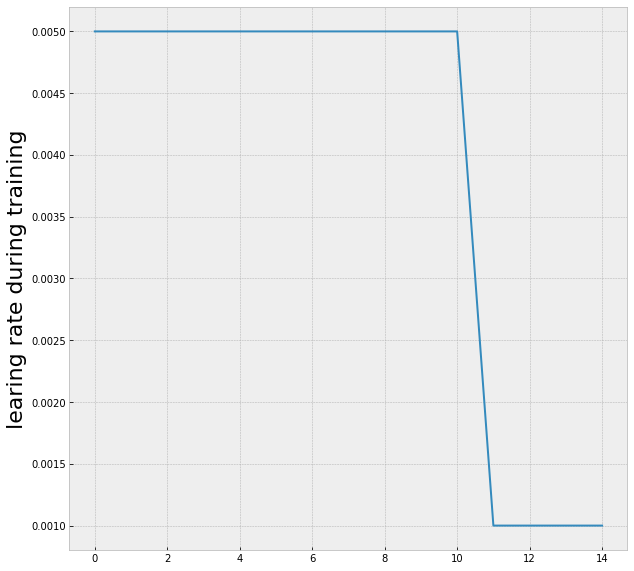

In [0]:
plt.figure(figsize=(10,10))
plt.plot([i[0] for i in lr_rate_list])
plt.ylabel('learing rate during training', fontsize=22)
plt.show()

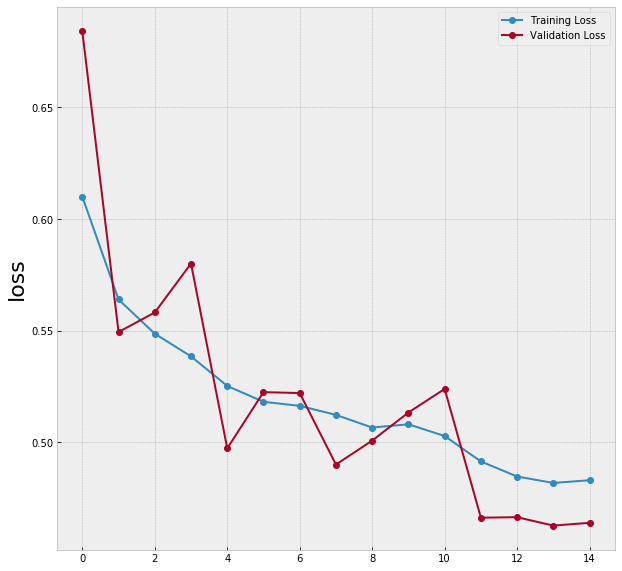

In [0]:
plt.figure(figsize=(10,10))
plt.plot(train_loss_list,  marker='o', label="Training Loss")
plt.plot(valid_loss_list,  marker='o', label="Validation Loss")
plt.ylabel('loss', fontsize=22)
plt.legend()
plt.show()

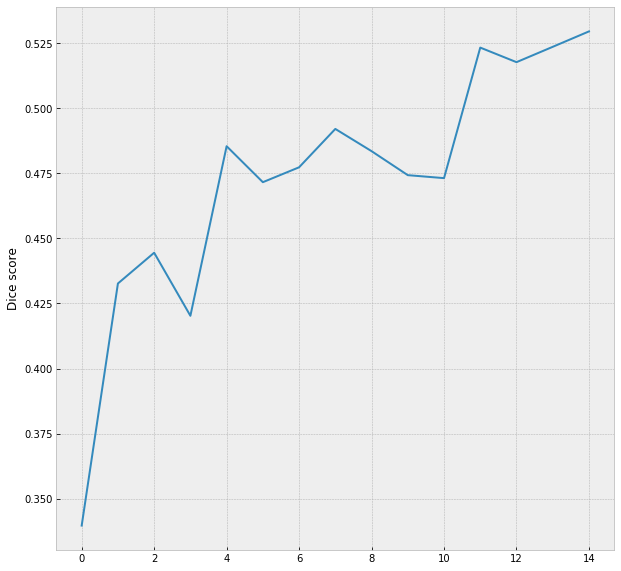

In [0]:
plt.figure(figsize=(10,10))
plt.plot(dice_score_list)
plt.ylabel('Dice score')
plt.show()

## Evaluate on Validation Set

In [0]:
# load best model
model.load_state_dict(torch.load('model_cifar.pt'))
model.eval()

UNet(
  (inc): inconv(
    (conv): double_conv(
      (conv): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
    )
  )
  (down1): down(
    (mpconv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): double_conv(
        (conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2

## Validation Prediction:

*   INPUT: len(valid_loader.dataset) 52*4 = 208
1.   Batch - data.shape - torch.Size([Batch 12, Channel 3, height 320, width 640]) 
2.   target.shape (Batch 12, Class 4, height 320, width 640)


*   OUTPUT: 
1. probabilities - Number of Valid * Number of Classes, Height, Width - (208, 350, 525) - each class and pixel
2. valid_masks - masks - Number of Valid Image * Number of Classes 208




In [0]:
valid_masks = []
count = 0
tr = min(len(valid_ids)*4, 2000)
probabilities = np.zeros((tr, 350, 525), dtype = np.float32)
print ("Input Validation Size", len(valid_loader.dataset) )
for data, target in tq(valid_loader):
    if train_on_gpu:
        data = data.cuda()
    target = target.cpu().detach().numpy()
    outpu = model(data).cpu().detach().numpy()
    #pdb.set_trace()
    for p in range(data.shape[0]):
        output, mask = outpu[p], target[p]
        #print("output", output.shape)
        #print("mask", mask.shape)
        for m in mask:
            valid_masks.append(resize_it(m))
        for probability in output:
            probabilities[count, :, :] = resize_it(probability)
            count += 1
        if count >= tr - 1:
            break
    if count >= tr - 1:
        break

print ("Output Probabilities Shape", probabilities.shape )
print ("Output Masks Size", len(valid_masks) )

Input Validation Size 1111


Output Probabilities Shape (2000, 350, 525)
Output Masks Size 2000


## Post Processing -Grid Search for best Threshold

https://www.kaggle.com/ratthachat/cloud-convexhull-polygon-postprocessing-no-gpu/data

In [0]:
%%time
class_params = {}
for class_id in range(4):
    print(class_id)
    attempts = []
    for t in range(0, 100, 5): ## threshold from 0,5,10,15...100
        t /= 100
        for ms in [0, 100, 1200, 5000, 10000, 30000]:
            masks, d = [], []
            for i in range(class_id, len(probabilities), 4):
                probability = probabilities[i]
                predict, num_predict = post_process(probability, t, ms) #probability, threshold, min_size
                masks.append(predict)
            for i, j in zip(masks, valid_masks[class_id::4]):
                if (i.sum() == 0) & (j.sum() == 0):
                    d.append(1)
                else:
                    d.append(dice(i, j))
            attempts.append((t, ms, np.mean(d)))

    attempts_df = pd.DataFrame(attempts, columns=['threshold', 'size', 'dice'])
    attempts_df = attempts_df.sort_values('dice', ascending=False)
    print(attempts_df.head())
    best_threshold = attempts_df['threshold'].values[0]
    best_size = attempts_df['size'].values[0]
    class_params[class_id] = (best_threshold, best_size)

0
     threshold   size      dice
101       0.80  30000  0.584562
95        0.75  30000  0.583850
107       0.85  30000  0.582463
89        0.70  30000  0.577526
113       0.90  30000  0.576421
1
    threshold   size      dice
47       0.35  30000  0.714401
71       0.55  30000  0.714318
41       0.30  30000  0.713528
53       0.40  30000  0.711408
95       0.75  30000  0.710499
2


In [0]:
attempts_df = pd.DataFrame(attempts, columns=['threshold', 'size', 'dice'])
print(class_params)

In [0]:
attempts_df.groupby(['threshold'])['dice'].max()

In [0]:
attempts_df.groupby(['size'])['dice'].max()

In [0]:
attempts_df = attempts_df.sort_values('dice', ascending=False)
attempts_df.head(10)

In [0]:
sns.lineplot(x='threshold', y='dice', hue='size', data=attempts_df);
plt.title('Threshold and min size vs dice');

In [0]:
best_threshold = attempts_df['threshold'].values[0]
best_size = attempts_df['size'].values[0]

https://www.kaggle.com/ratthachat/cloud-convexhull-polygon-postprocessing-no-gpu/data

In [0]:
for i, (data, target) in enumerate(valid_loader):
    if train_on_gpu:
        data = data.cuda()
    output = ((model(data))[0]).cpu().detach().numpy()
    image  = data[0].cpu().detach().numpy()
    mask   = target[0].cpu().detach().numpy()
    output = output.transpose(1 ,2, 0)
    image_vis = image.transpose(1, 2, 0)
    mask = mask.astype('uint8').transpose(1, 2, 0)
    pr_mask = np.zeros((350, 525, 4))
    for j in range(4):
        probability = resize_it(output[:, :, j])
        pr_mask[:, :, j], _ = post_process(probability,
                                           class_params[j][0],
                                           class_params[j][1]) #probability, threshold, min_size
    visualize_with_raw(image=image_vis, mask=pr_mask,
                      original_image=image_vis, original_mask=mask,
                      raw_image=image_vis, raw_mask=output)
    if i >= 6:
        break

## Kaggle Submission

In [0]:
subm = pd.read_csv("/content/data/sample_submission.csv")
pathlist = ["/content/data/test_images_525/test_images_525/" + i.split("_")[0] for i in subm['Image_Label']]

In [0]:
encoded_pixels = []
image_id = 0
cou = 0
np_saved = 0
for data, target in tq(test_loader):
    if train_on_gpu:
        data = data.cuda()
    output = model(data)
    del data
    for i, batch in enumerate(output):
        for probability in batch:
            probability = resize_it(probability.cpu().detach().numpy())
            predict, num_predict = post_process(probability,
                                                class_params[image_id % 4][0],
                                                class_params[image_id % 4][1])
            if num_predict == 0:
                encoded_pixels.append('')
            else:
                black_mask = get_black_mask(pathlist[cou])
                np_saved += np.sum(predict)
                predict = np.multiply(predict, black_mask)
                np_saved -= np.sum(predict)
                r = mask2rle(predict)
                encoded_pixels.append(r)
            cou += 1
            image_id += 1

print(f"number of pixel saved {np_saved}")

In [0]:
sub['EncodedPixels'] = encoded_pixels
sub.to_csv('submission.csv', columns=['Image_Label', 'EncodedPixels'], index=False)